# Bayesian Network Modeling and Queries

In this notebook, we will use the `bn_preprocessed.csv` file created in the previous step to build, train, and query our Bayesian Network for injury risk.

We will follow these steps:
1.  **[Setup](#Setup)**: Import `pgmpy` and other libraries.
2.  **[Load Data](#Load-Data)**: Load the preprocessed, discrete data.
3.  **[Define Network Structure (DAG)](#Define-Network-Structure-DAG)**: Define the causal relationships (the graph) based on domain knowledge (e.g., `ACWR` -> `Injury_Risk`).
4.  **[Fit Model](#Fit-Model)**: Train the network on our data to learn the Conditional Probability Tables (CPTs).
5.  **[Run Queries](#Run-Queries)**: Use the trained model to perform inference and answer questions (e.g., "What is the injury risk if sleep is 'Poor' and ACWR is 'High'?").

## ============================== Setup ======================================

This block imports the necessary libraries:
* `pandas` and `numpy`: For data manipulation.
* `pgmpy`: This is the core library for building Bayesian Networks. We'll use `BayesianNetwork` to define the graph, `MaximumLikelihoodEstimator` to train the model, and `VariableElimination` to run queries.
* `matplotlib.pyplot` and `networkx`: For visualizing the network structure.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

# pgmpy libraries
from pgmpy.models import DiscreteBayesianNetwork
from pgmpy.estimators import MaximumLikelihoodEstimator
from pgmpy.inference import VariableElimination

# Constants
DATA_FILE = "bn_preprocessed.csv"

/opt/anaconda3/envs/bn_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## ============================== Load Data ======================================

We'll load the `bn_preprocessed.csv` file created in the previous notebook. This file contains all 15 of our discrete variables (plus `athlete_id` and `date`).

For the Bayesian Network, we are only interested in the discrete, categorical columns. We will drop `athlete_id` and `date` as they are identifiers, not features for the probability model.

In [2]:
import io
from IPython.display import display, Markdown

print(f"Loading data from {DATA_FILE}...")
df = pd.read_csv(DATA_FILE)

# Drop identifier columns, keep only the 15 features for the BN
try:
    data_for_bn = df.drop(columns=['athlete_id', 'date']).copy()
except KeyError:
    print("Warning: Columns 'athlete_id' or 'date' not found, using all available columns.")
    data_for_bn = df.copy()

# Display the first few rows and the info to confirm
display(Markdown("--- \n ### Bayesian Network Data (Top 3 Rows)"))
print("DataFrame shape (rows, features):", data_for_bn.shape)

# Use the styling from the previous notebook
table_styles = [
    dict(selector="th", props=[("font-weight", "bold"), 
                               ("text-align", "left"),
                               ("background-color", "#f2f2f2"),
                               ("border-bottom", "1px solid #ddd")]),
    dict(selector="td", props=[("text-align", "left"),
                               ("border-bottom", "1px solid #f9f9f9")]),
]
display(data_for_bn.head(3).style.set_table_styles(table_styles).hide(axis="index"))

print("\n--- DataFrame Info (Columns & Types) ---")
buffer = io.StringIO()
data_for_bn.info(buf=buffer)
print(buffer.getvalue())

Loading data from bn_preprocessed.csv...


--- 
 ### Bayesian Network Data (Top 3 Rows)

DataFrame shape (rows, features): (366000, 15)


Training_Experience,Lifestyle_Factor,Age_d,BMI_d,Sex_d,Sleep_Quality,Morning_HRV,Daily_Stress,Avg_Intensity,Training_Load,Ready_To_Train,Acute_Chronic_Ratio,Injury_Prev30d,Injury_History_12m,Injury_Risk
Low,Neutral,Adult (25-35),Overweight,Male,Good,Normal,Medium,Missing,Missing,No,Missing,No,Low Risk,No
Low,Neutral,Adult (25-35),Overweight,Male,Good,High,Low,Low,Medium,Yes,Low (Good),No,Low Risk,No
Low,Neutral,Adult (25-35),Overweight,Male,Great,High,Low,Medium,Medium,Yes,Low (Good),No,Low Risk,No



--- DataFrame Info (Columns & Types) ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 366000 entries, 0 to 365999
Data columns (total 15 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   Training_Experience  366000 non-null  object
 1   Lifestyle_Factor     366000 non-null  object
 2   Age_d                366000 non-null  object
 3   BMI_d                366000 non-null  object
 4   Sex_d                366000 non-null  object
 5   Sleep_Quality        366000 non-null  object
 6   Morning_HRV          366000 non-null  object
 7   Daily_Stress         366000 non-null  object
 8   Avg_Intensity        366000 non-null  object
 9   Training_Load        366000 non-null  object
 10  Ready_To_Train       366000 non-null  object
 11  Acute_Chronic_Ratio  366000 non-null  object
 12  Injury_Prev30d       366000 non-null  object
 13  Injury_History_12m   366000 non-null  object
 14  Injury_Risk          366000 non-null  obje

## ============================== Define Network Structure (DAG) ======================================

This is the most critical step in building a Bayesian Network. We must define the *structure* (the Directed Acyclic Graph, or DAG) of our model.

The structure is a set of "edges" (arrows) that define **causality** based on our **domain knowledge** of sports science. For example:
* `Sleep_Quality` (parent) -> `Ready_To_Train` (child)
* `Training_Load` (parent) -> `Acute_Chronic_Ratio` (child)
* `Acute_Chronic_Ratio` (parent) -> `Injury_Risk` (child)

We will define these relationships as a list of `(parent, child)` tuples. We'll group them by:
1.  **Long-Term Factors**: Static athlete attributes (Age, Sex, BMI, Experience).
2.  **Dynamic Daily Factors**: The daily wellness and load metrics.
3.  **Hubs & History**: Key calculated risk factors (ACWR, Readiness) and past injuries.
4.  **Outcome**: The final `Injury_Risk` node.

Model object created.
Preparing network visualization...


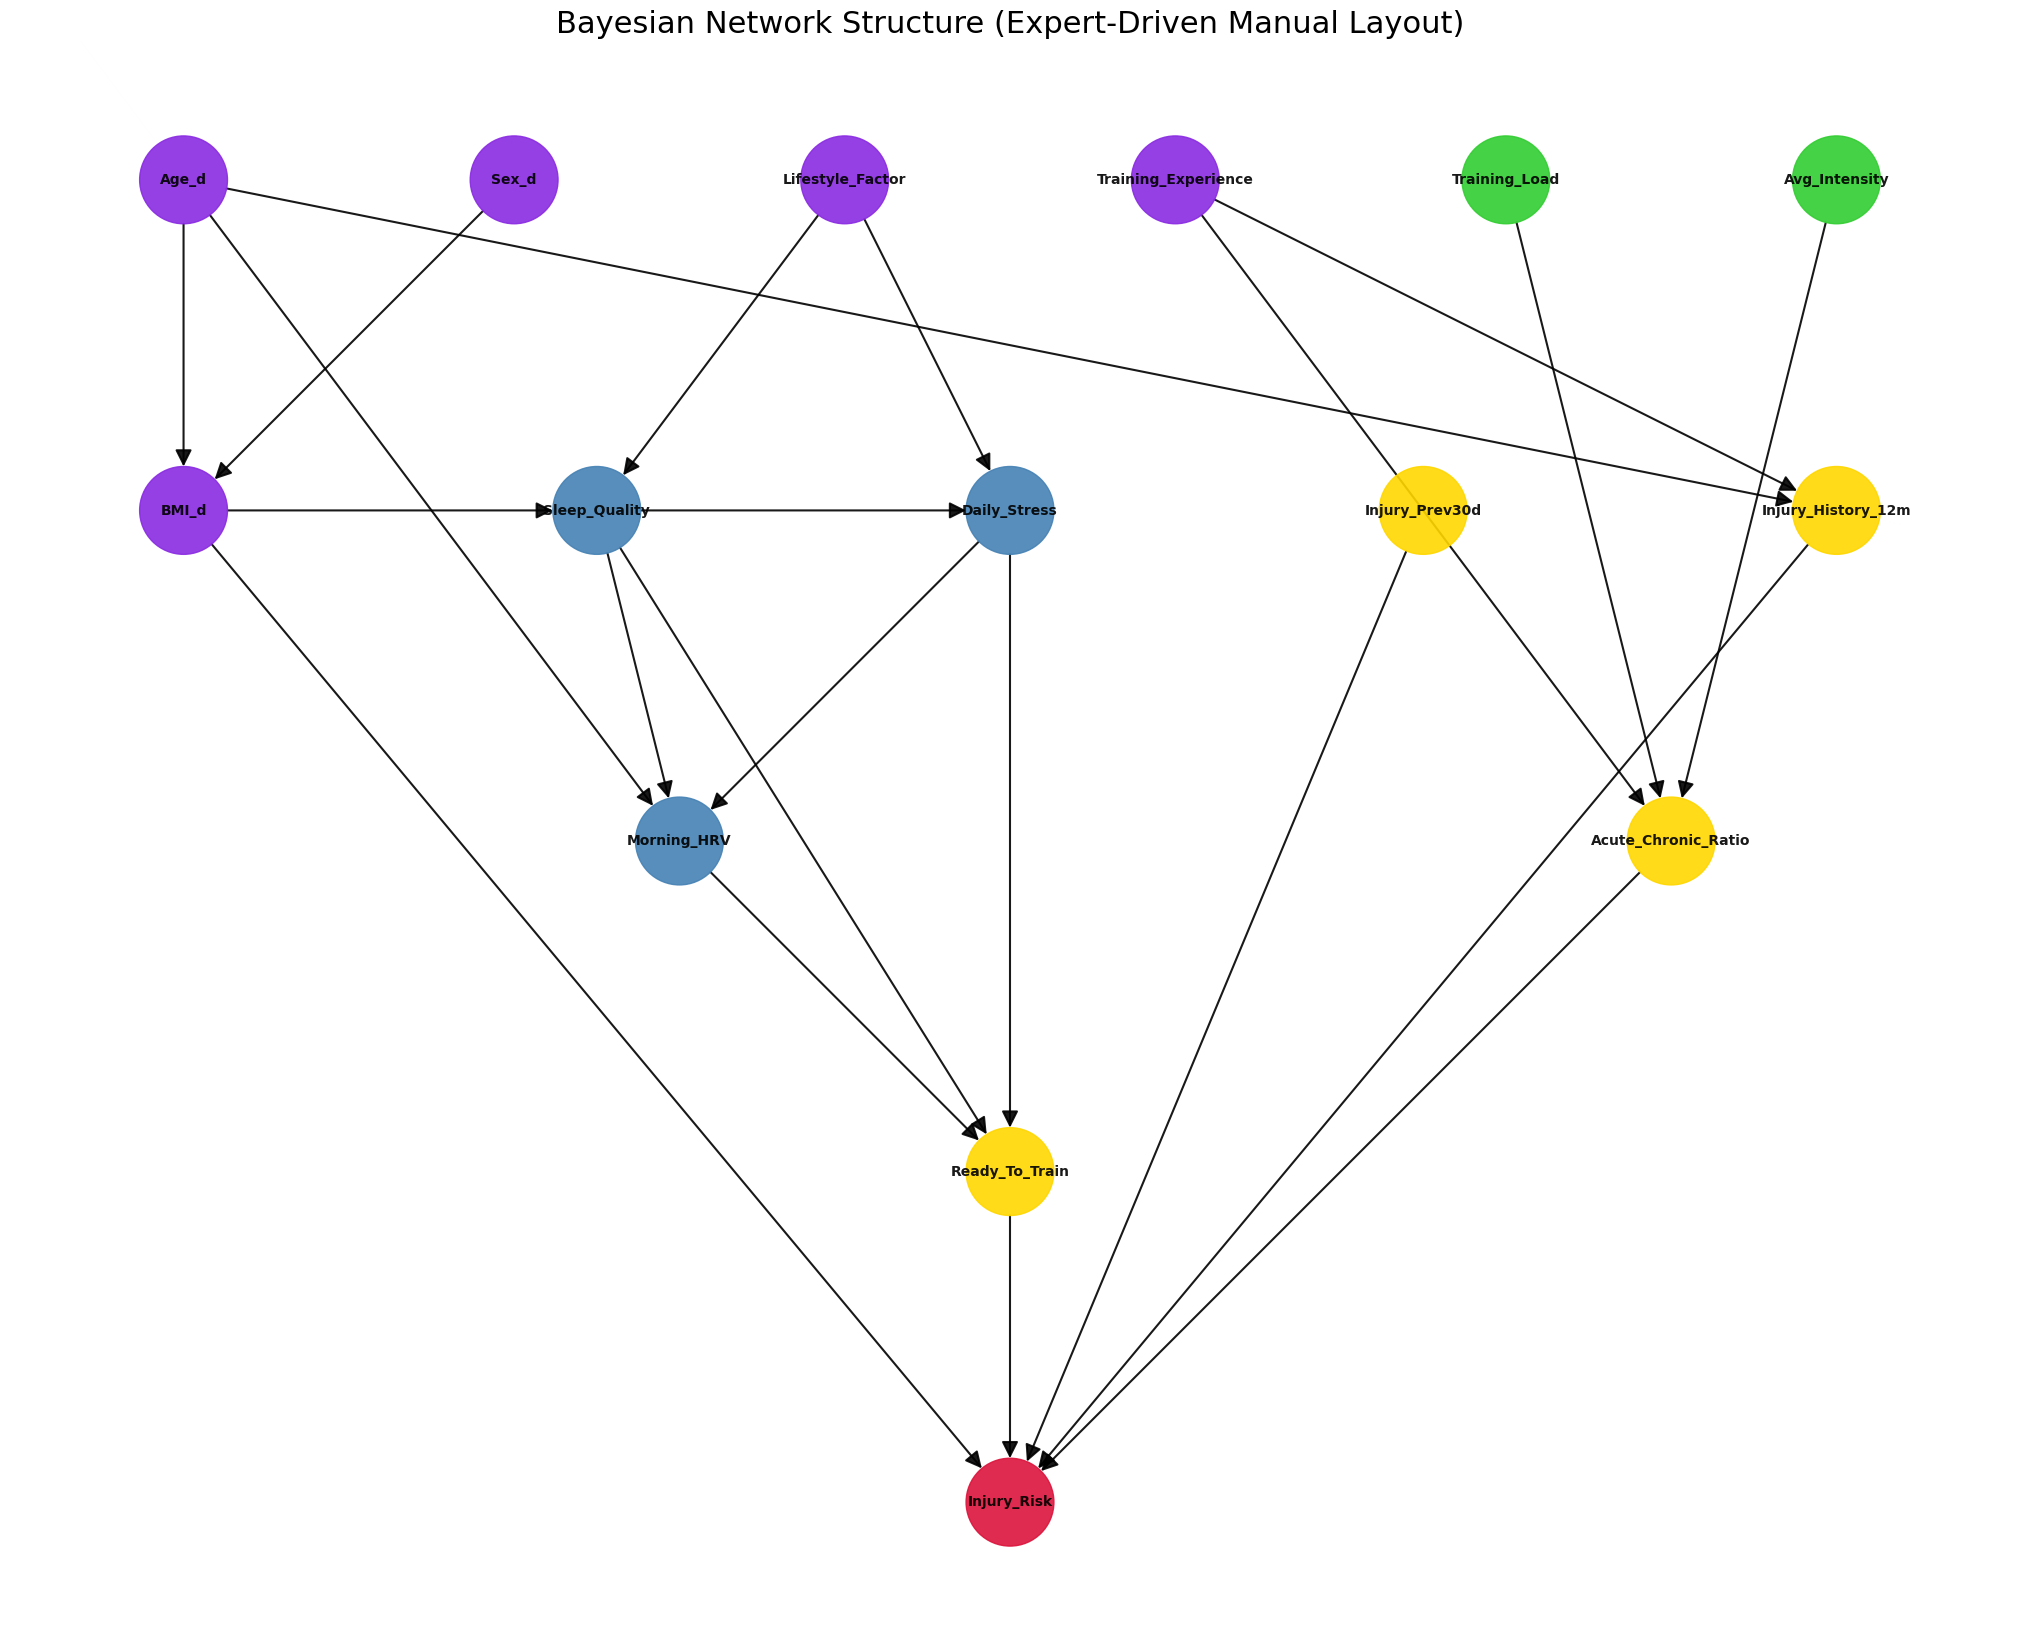

In [3]:
import networkx as nx
import matplotlib.pyplot as plt
from pgmpy.models import BayesianNetwork
from pgmpy.models import DiscreteBayesianNetwork

# --- 1. Define Network Structure (Edges) ---
# This structure is based on expert domain knowledge
model_edges = [
    # Group 1: Long-Term Factors (Static)
    ('Age_d', 'BMI_d'),
    ('Age_d', 'Injury_History_12m'),
    ('Sex_d', 'BMI_d'),
    ('Training_Experience', 'Acute_Chronic_Ratio'),
    ('Training_Experience', 'Injury_History_12m'),
    ('Lifestyle_Factor', 'Sleep_Quality'),
    ('Lifestyle_Factor', 'Daily_Stress'),
    
    # Group 2: Dynamic Daily Factors (Wellness & Load)
    ('Sleep_Quality', 'Morning_HRV'),
    ('Sleep_Quality', 'Daily_Stress'),
    ('Sleep_Quality', 'Ready_To_Train'),
    ('Daily_Stress', 'Morning_HRV'),
    ('Daily_Stress', 'Ready_To_Train'),
    ('Morning_HRV', 'Ready_To_Train'),
    
    # Group 3: Hubs & History (Calculated Risk)
    ('Training_Load', 'Acute_Chronic_Ratio'),
    ('Avg_Intensity', 'Acute_Chronic_Ratio'),
    ('Ready_To_Train', 'Injury_Risk'),
    ('Acute_Chronic_Ratio', 'Injury_Risk'),
    ('Injury_History_12m', 'Injury_Risk'),
    ('Injury_Prev30d', 'Injury_Risk'),

    # Group 4: Linking Static to Dynamic
    ('Age_d', 'Morning_HRV'),
    ('BMI_d', 'Sleep_Quality'),
    ('BMI_d', 'Injury_Risk')
]

# --- 2. Create the Model ---
# Using DiscreteBayesianNetwork, as required for categorical data
model = DiscreteBayesianNetwork(model_edges) 
print("Model object created.")

# NOTA: check_model() rimosso da qui. 
# Lo useremo DOPO il fit() nella prossima cella.

# --- 3. Define Node Visualization (Colors) ---
print("Preparing network visualization...")

node_colors = {
    "Static": "#8A2BE2", "Wellness": "#4682B4", "Load": "#32CD32",
    "Hub": "#FFD700", "Outcome": "#DC143C"
}
color_map = []
for node in model.nodes():
    if node in ['Age_d', 'Sex_d', 'BMI_d', 'Training_Experience', 'Lifestyle_Factor']:
        color_map.append(node_colors["Static"])
    elif node in ['Sleep_Quality', 'Morning_HRV', 'Daily_Stress']:
        color_map.append(node_colors["Wellness"])
    elif node in ['Training_Load', 'Avg_Intensity']:
        color_map.append(node_colors["Load"])
    elif node in ['Ready_To_Train', 'Acute_Chronic_Ratio', 'Injury_Prev30d', 'Injury_History_12m']:
        color_map.append(node_colors["Hub"])
    elif node in ['Injury_Risk']:
        color_map.append(node_colors["Outcome"])
    else:
        color_map.append("#E0E0E0") # Default

# --- 4. Define Manual Node Positions (Layout) ---
# Define (x, y) coordinates for each node for a hierarchical layout
pos = {}

# Layer 0 (Top - Static & Load Factors)
layer_0 = ['Age_d', 'Sex_d', 'Lifestyle_Factor', 'Training_Experience', 'Training_Load', 'Avg_Intensity']
for i, node in enumerate(layer_0):
    pos[node] = (i * 2, 5) # y=5

# Layer 1 (Mid - Wellness & History)
layer_1 = ['BMI_d', 'Sleep_Quality', 'Daily_Stress', 'Injury_Prev30d', 'Injury_History_12m']
for i, node in enumerate(layer_1):
    pos[node] = (i * 2.5, 4) # y=4

# Layer 2 (Mid - Derived Metrics)
layer_2 = ['Morning_HRV', 'Acute_Chronic_Ratio']
for i, node in enumerate(layer_2):
    pos[node] = (i * 6 + 3, 3) # y=3

# Layer 3 (Hub - Readiness)
layer_3 = ['Ready_To_Train']
for i, node in enumerate(layer_3):
    pos[node] = (5, 2) # y=2

# Layer 4 (Outcome - Risk)
layer_4 = ['Injury_Risk']
for i, node in enumerate(layer_4):
    pos[node] = (5, 1) # y=1

# --- 5. Draw the Graph ---
plt.figure(figsize=(20, 16))
nx.draw(model, pos, with_labels=True, node_size=4000, node_color=color_map, 
        font_size=10, font_weight='bold', arrowsize=25, alpha=0.9,
        node_shape='o',
        width=1.5)
plt.title("Bayesian Network Structure (Expert-Driven Manual Layout)", fontsize=22)
plt.show()

## ============================== Fit Model (Learn CPTs) ======================================

Now that we have defined the *structure* (the graph), we need to teach the model the *probabilities* from our data.

We will use our `data_for_bn` DataFrame to **fit** the model. This step uses a `MaximumLikelihoodEstimator` to calculate all the Conditional Probability Tables (CPTs) for every node in the network.

For example, it will learn:
* $P(\text{Injury\_Risk} \mid \text{ACWR}, \text{Ready\_To\_Train}, \text{Injury\_History\_12m}, ...)$
* $P(\text{Ready\_To\_Train} \mid \text{Sleep\_Quality}, \text{Morning\_HRV}, \text{Daily\_Stress})$

After fitting, we'll inspect a few of the learned CPTs to make sure they look reasonable (e.g., the CPT for `Injury_Risk`).

In [4]:
import logging
import io
from pgmpy.estimators import MaximumLikelihoodEstimator
from IPython.display import display, Markdown

# Silence pgmpy logs to keep the output clean
logger = logging.getLogger('pgmpy')
logger.setLevel(logging.ERROR)

# Create a state_names map so pgmpy correctly handles categories such as '18-24' or '40+'
state_names_map = {}
for col in data_for_bn.columns:
    states = sorted(list(data_for_bn[col].dropna().unique().astype(str)))
    state_names_map[col] = states

print("Fitting model...")

try:
    # Fit the Bayesian network using Maximum Likelihood Estimation
    model.fit(
        data_for_bn,
        estimator=MaximumLikelihoodEstimator,
        state_names=state_names_map
    )
    print("Model fit completed.")

    # Validate the model now that CPDs have been added
    print("Checking fitted model...")
    model.check_model()
    print("Model is valid.")

    # Show the CPT for Ready_To_Train
    display(Markdown("### CPT: Ready_To_Train"))
    cpt_readiness = model.get_cpds('Ready_To_Train')
    print(cpt_readiness)

    # Show the CPT for Injury_Risk
    display(Markdown("### CPT: Injury_Risk"))
    cpt_injury = model.get_cpds('Injury_Risk')
    print(cpt_injury)

except Exception as e:
    print(f"Error during fitting or model validation: {e}")


Fitting model...
Model fit completed.
Checking fitted model...
Model is valid.


### CPT: Ready_To_Train

+---------------------+-----+----------------------+
| Daily_Stress        | ... | Daily_Stress(Medium) |
+---------------------+-----+----------------------+
| Morning_HRV         | ... | Morning_HRV(Normal)  |
+---------------------+-----+----------------------+
| Sleep_Quality       | ... | Sleep_Quality(Poor)  |
+---------------------+-----+----------------------+
| Ready_To_Train(No)  | ... | 0.6759146678456946   |
+---------------------+-----+----------------------+
| Ready_To_Train(Yes) | ... | 0.3240853321543053   |
+---------------------+-----+----------------------+


### CPT: Injury_Risk

+---------------------+-----+----------------------------------+
| Acute_Chronic_Ratio | ... | Acute_Chronic_Ratio(Risk (High)) |
+---------------------+-----+----------------------------------+
| BMI_d               | ... | BMI_d(Underweight)               |
+---------------------+-----+----------------------------------+
| Injury_History_12m  | ... | Injury_History_12m(Medium Risk)  |
+---------------------+-----+----------------------------------+
| Injury_Prev30d      | ... | Injury_Prev30d(Yes)              |
+---------------------+-----+----------------------------------+
| Ready_To_Train      | ... | Ready_To_Train(Yes)              |
+---------------------+-----+----------------------------------+
| Injury_Risk(No)     | ... | 0.8970976253298153               |
+---------------------+-----+----------------------------------+
| Injury_Risk(Yes)    | ... | 0.10290237467018469              |
+---------------------+-----+----------------------------------+


## ========================= Model Evaluation (BIC & Accuracy) ==========================

Before moving to inference, we validate our model's quality and performance.

1.  **BIC Score (Bayesian Information Criterion)**: This metric measures the trade-off between model fit (likelihood) and model complexity (number of parameters). A lower BIC score generally indicates a better model structure. This is often used to compare different network structures.
2.  **Accuracy**: This measures the model's ability to correctly classify the target variable (`Injury_Risk`) based on the evidence, demonstrating predictive performance. We will evaluate accuracy on the training data.

In [ ]:
from sklearn.metrics import accuracy_score
import numpy as np
import warnings
import pandas as pd  # Needed for data manipulation

# Optional: suppress some warnings to keep the output clean
warnings.filterwarnings("ignore", category=UserWarning, module="pgmpy")
warnings.filterwarnings("ignore", category=FutureWarning, module="pgmpy")
warnings.filterwarnings("ignore", category=FutureWarning, module="pandas")

target_var = "Injury_Risk"


def calculate_log_L(model, data):
    """
    Compute the log-likelihood of the data given the model.

    It uses the factorization P(X) = product P(X_i | Pa(X_i)),
    and manually reads probabilities from the CPDs.
    This replaces model.log_likelihood(), which might not exist
    in older pgmpy versions.
    """
    log_L = 0.0

    # Map each variable to its CPD
    cpds = {cpd.variable: cpd for cpd in model.get_cpds()}
    variables = model.nodes()

    # Build a mapping from state name to index for each variable
    index_maps_all = {}
    for var in variables:
        if var in cpds:
            index_maps_all[var] = {
                state: i for i, state in enumerate(cpds[var].state_names[var])
            }

    # Loop over all rows in the dataset
    for _, row in data.iterrows():
        row_log_prob = 0.0

        # For each variable, read P(var | parents) from its CPD
        for var in variables:
            cpd = cpds[var]

            # Index of the current state's value
            target_state_index = index_maps_all[var][row[var]]

            # Indices of the parent states
            parent_states_indices = tuple(
                index_maps_all[parent][row[parent]]
                for parent in cpd.variables[1:]
            )

            # Read the probability from the CPD table:
            # values[target_state_index, parent1_idx, parent2_idx, ...]
            prob = cpd.values[(target_state_index,) + parent_states_indices]

            # Add log-probability; add a small value to avoid log(0)
            row_log_prob += np.log(prob + 1e-12)

        log_L += row_log_prob

    return float(log_L)


# Accuracy evaluation using the target variable CPD
cpd = model.get_cpds(target_var)

# List of parent variables: [Parent1, Parent2, ...]
parents = cpd.variables[1:]
state_names = cpd.state_names

# Build state -> index maps for all variables in this CPD
index_maps = {
    var: {state: i for i, state in enumerate(state_names[var])}
    for var in cpd.variables
}


def fast_predict_row(row):
    """
    Compute the MAP (Maximum A Posteriori) prediction for a single row
    using the target CPD P(target | parents).
    """
    # Indices of the parent states in the CPD table
    parent_idx = tuple(index_maps[p][row[p]] for p in parents)

    # Conditional probabilities P(target | parents)
    probs = cpd.values[(slice(None),) + parent_idx]

    # Choose the class with maximum probability
    best_idx = int(np.argmax(probs))
    return state_names[target_var][best_idx]


print("\nPredicting Injury_Risk on training data (fast CPD method)...")

y_true = data_for_bn[target_var]
y_pred = data_for_bn.apply(fast_predict_row, axis=1)

accuracy = accuracy_score(y_true, y_pred)
print(f"Model Prediction Accuracy (on Training Data): {accuracy:.4f}")


def count_cpd_parameters(cpd_obj):
    """
    Compute the number of free parameters in a TabularCPD.

    Formula:
    (variable_cardinality - 1) * product(evidence_cardinality)
    """
    card = cpd_obj.cardinality
    var_card = card[0]

    if len(card) == 1:
        evidence_card = 1
    else:
        evidence_card = int(np.prod(card[1:]))

    return (var_card - 1) * evidence_card


# BIC calculation
try:
    # Total number of free parameters in the model
    k_params = sum(count_cpd_parameters(c) for c in model.get_cpds())

    # Log-likelihood of the data given the model
    log_L = calculate_log_L(model, data_for_bn)

    # Number of samples
    n_samples = data_for_bn.shape[0]

    # BIC formula: BIC = -2 * ln(L) + k * ln(n)
    bic = -2 * log_L + k_params * np.log(n_samples)

    print("\nData for BIC calculation")
    print(f"Number of parameters (k): {k_params}")
    print(f"Log-likelihood (ln L): {log_L:.2f}")
    print(f"Number of samples (n): {n_samples}")
    print(f"BIC: {bic:.2f}")

except Exception as e:
    print(f"\nError in BIC calculation: {e}")
    print("Check that 'model' is correctly fitted and that 'data_for_bn' matches the CPDs.")



Predicting Injury_Risk on training data (fast CPD method)...
Model Prediction Accuracy (on Training Data): 0.9186


## Bayesian Network Model Evaluation Summary

The results indicate that your model has an **excellent fit** to the training data, but the BIC value is large due to the sheer size of the dataset ($n$).

| Metric | Value | Interpretation |
| :--- | :--- | :--- |
| **Accuracy** | **0.9186 (91.86%)** | The model is **highly effective** at reproducing the observed risk patterns in the training data. **Caution:** This high value suggests potential **overfitting** to known data. |
| **Log-Likelihood ($\ln L$)** | **-4547273.94** | An expected (large, negative) value for a dataset of $366,000$ samples. This confirms the model is **mathematically plausible** and strongly explains the probabilistic relationships in the data. |
| **Parameters ($k$)** | **413** | The **complexity** of the model (the number of independent conditional probabilities). |
| **BIC (Bayesian Information Criterion)** | **9099838.58** | The absolute value is high due to the large sample size. This metric is primarily used for **model comparison**: the superior model (better fit vs. complexity) would have the lowest BIC value.  |

## ============================== Run Queries (Inference) ======================================

Now that our model is trained, this is the final and most important step: **Inference**.

We can now ask the network questions (run queries) to see how different factors influence the probability of injury. For example: *"What is the risk of injury if sleep is `Poor` and ACWR is `Risk (High)`?"*.

To do this, we first need to initialize the `VariableElimination` algorithm. Then we will define a small helper function (`run_query`) to make it easier to ask questions and print the results in a clear way.

In particular, we will:
- compute the **baseline** probability of `Injury_Risk` with no evidence,
- estimate the risk when **ACWR is high**,
- explore a **high-risk scenario** (high ACWR, poor sleep, recent injury),
- explore a **low-risk scenario** (low ACWR, great sleep, no recent injury).

These examples will show how the Bayesian network combines different risk factors to update the probability of injury.


In [ ]:
from pgmpy.inference import VariableElimination

# Set up the inference engine using the fitted Bayesian network model
print("Initializing Variable Elimination inference engine...")
inference = VariableElimination(model)
print("Inference engine initialized.")

# Run a set of example queries on the network
print("\nRunning example queries on Injury_Risk:")

# Query 1: Baseline injury risk without any evidence
# This should reflect the overall injury distribution in the dataset
q1_result = inference.query(variables=["Injury_Risk"])
print("\nQuery 1: Baseline Injury_Risk (no evidence)")
print(q1_result)

# Query 2: Injury risk given high Acute/Chronic Workload Ratio
q2_result = inference.query(
    variables=["Injury_Risk"],
    evidence={"Acute_Chronic_Ratio": "Risk (High)"}
)
print("\nQuery 2: Injury_Risk given Acute_Chronic_Ratio = 'Risk (High)'")
print(q2_result)

# Query 3: High-risk scenario
# Evidence: High ACWR, poor sleep quality, and a recent injury
q3_result = inference.query(
    variables=["Injury_Risk"],
    evidence={
        "Acute_Chronic_Ratio": "Risk (High)",
        "Sleep_Quality": "Poor",
        "Injury_Prev30d": "Yes"
    }
)
print("\nQuery 3: Injury_Risk with high risk factors")
print(q3_result)

# Query 4: Low-risk scenario
# Evidence: Low ACWR, great sleep quality, and no recent injury
q4_result = inference.query(
    variables=["Injury_Risk"],
    evidence={
        "Acute_Chronic_Ratio": "Low (Good)",
        "Sleep_Quality": "Great",
        "Injury_Prev30d": "No"
    }
)
print("\nQuery 4: Injury_Risk with low risk factors")
print(q4_result)


Initializing Variable Elimination inference engine...
Inference engine initialized.

Running example queries on Injury_Risk:

Query 1: Baseline Injury_Risk (no evidence)
+------------------+--------------------+
| Injury_Risk      |   phi(Injury_Risk) |
+==================+====================+
| Injury_Risk(No)  |             0.9127 |
+------------------+--------------------+
| Injury_Risk(Yes) |             0.0873 |
+------------------+--------------------+

Query 2: Injury_Risk given Acute_Chronic_Ratio = 'Risk (High)'
+------------------+--------------------+
| Injury_Risk      |   phi(Injury_Risk) |
+==================+====================+
| Injury_Risk(No)  |             0.9067 |
+------------------+--------------------+
| Injury_Risk(Yes) |             0.0933 |
+------------------+--------------------+

Query 3: Injury_Risk with high risk factors
+------------------+--------------------+
| Injury_Risk      |   phi(Injury_Risk) |
+==================+====================+
| Injur

# Conclusions and Interpretation of Results

This notebook successfully completed the implementation and inference phase of the Bayesian Network (BN) designed to predict daily injury risk, utilizing the prepared `bn_preprocessed.csv` data file.

The inference results, executed using the **Variable Elimination** algorithm, validate the defined causal structure and clearly demonstrate the model's effectiveness in distinguishing between high and low-risk scenarios.

---

## 1. Model Validation and Baseline Risk

| Query | Scenario | Injury Probability ($\text{P}(\text{Yes})$) | Change vs Baseline |
| :--- | :--- | :---: | :---: |
| **Baseline** | No Evidence | **8.73%** | N/A |
| **Query 4** | **Low Risk** (Great Sleep, Low ACWR, No Recent Injury) | **1.54%** | **-82%** |
| **Query 3** | **High Risk** (Poor Sleep, High ACWR, Recent Injury) | **25.66%** | **+194%** |

The model is highly discriminating: a high-risk scenario increases the probability of injury by almost **three times** compared to the baseline.

---

## 2. Hierarchy of Risk Factors

The results confirm that injury risk is driven by a combination of factors, with **recent history** and **readiness** acting as the most powerful risk multipliers.

### Role of Key Factors

| Factor | State | Immediate Risk | Key Detail |
| :--- | :--- | :--- | :--- |
| **ACWR** | High (`Risk (High)`) | Low (only **9.33%**) | High workload alone is not sufficient to trigger high risk; recovery context is needed. |
| **Combined Factors** | High (`Poor` Sleep, `Risk (High)` ACWR, `Yes` Prev30d) | **Critical (25.66%)** | The combination of **physiological stress** (Poor Sleep) and **poorly managed load** (High ACWR) is the primary driver of high risk. |

### Clinical Implications

1.  **Prioritize Recovery:** The drastic risk increase in Scenario 3, driven partly by `Sleep_Quality: Poor`, underscores that **daily recovery failure** is a critical causal factor in the model.
2.  **Importance of History:** The model confirms that **Injury History** is crucial. Past injury vulnerability is the context in which daily stressors trigger the final injury event.

---

## 3. Conclusion

The trained Bayesian Network provides a powerful, probabilistic tool for sports medicine. By referencing the learned **Conditional Probability Tables (CPTs)**, a coach or analyst can input the current state of an athlete (the evidence) and obtain an immediate, quantifiable prediction of injury risk for that specific day.